# Исследование качества коров
Цели исследования:
- прогнозировать возможный удой коровы
- рассчитать вероятность получить вкусное молоко от коровы

Данные я возьму из файлов `ferma_main.csv`, `ferma_dad.csv`, `cow_buy.csv`

Ход исследования:
* Загрузка данных
* Предобработка данных
* Исследовательский анализ данных
* Корреляционный анализ
* Обучение модели линейной регрессии
* Обучение модели логистической регрессии
* Итоговый вывод

Содержание:
* [Загрузка данных](#first-bullet)
* [Предобработка данных](#second-bullet)
* [Исследовательский анализ данных](#third-bullet)
* [Корреляционный анализ](#fourth-bullet)
* [Обучение модели линейной регрессии](#fifth-bulet)
* [Обучение модели логистической регрессии](#sixth-bullet)
* [Итоговый вывод](#seventh-bullet)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install phik -q
from phik import phik_matrix
RANDOM_STATE = 42
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve)


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


<a class='anchor' id='first-bullet'></a>
## Загрузка данных

In [4]:
data_ferma = pd.read_csv('ferma_main.csv', sep=';', decimal=',')
data_dad = pd.read_csv('ferma_dad.csv', sep=';')
data_buy = pd.read_csv('cow_buy.csv', sep=';', decimal=',')
data_ferma.reset_index(drop=True, inplace=True)
data_ferma.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [5]:
data_ferma.rename(columns={
    'Удой, кг': 'yield',
    'ЭКЕ (Энергетическая кормовая единица)': 'ecu',
    'Сырой протеин, г': 'crude_protein',
    'СПО (Сахаро-протеиновое соотношение)': 'sps',
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'sire_breed',
    'Жирность,%': 'fat',
    'Белок,%': 'protein',
    'Вкус молока': 'milk_flavor',
    'Возраст': 'age'
}, inplace=True)
data_ferma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             634 non-null    int64  
 1   yield          634 non-null    int64  
 2   ecu            634 non-null    float64
 3   crude_protein  634 non-null    int64  
 4   sps            634 non-null    float64
 5   breed          634 non-null    object 
 6   pasture_type   634 non-null    object 
 7   sire_breed     634 non-null    object 
 8   fat            634 non-null    float64
 9   protein        634 non-null    float64
 10  milk_flavor    634 non-null    object 
 11  age            634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


In [6]:
data_dad.reset_index(drop=True, inplace=True)
data_dad.rename(columns={
    'Имя Папы': 'sire_name'
}, inplace=True)
data_dad.head()

,id,sire_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [7]:
data_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         629 non-null    int64 
 1   sire_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [8]:
data_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [9]:
data_buy.rename(columns={
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'sire_breed',
    'Имя_папы': 'sire_name',
    'Текущая_жирность,%': 'fat',
    'Текущий_уровень_белок,%': 'protein',
    'Возраст': 'age'
}, inplace=True)
data_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   breed         20 non-null     object 
 1   pasture_type  20 non-null     object 
 2   sire_breed    20 non-null     object 
 3   sire_name     20 non-null     object 
 4   fat           20 non-null     float64
 5   protein       20 non-null     float64
 6   age           20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Данные в таблицах совпадают с полученными в ТЗ, всего у нас 629 сущностей среди данных от фермера, 20 коров рассматриваются к покупке. 

<a class='anchor' id='second-bullet'></a>
##  Предобработка данных

In [12]:
data_ferma.isna().sum()

id               0
yield            0
ecu              0
crude_protein    0
sps              0
breed            0
pasture_type     0
sire_breed       0
fat              0
protein          0
milk_flavor      0
age              0
dtype: int64

In [13]:
data_dad.isna().sum()

id           0
sire_name    0
dtype: int64

In [14]:
data_buy.isna().sum()

breed           0
pasture_type    0
sire_breed      0
sire_name       0
fat             0
protein         0
age             0
dtype: int64

In [15]:
print(data_ferma['age'].unique())
print(data_buy['age'].unique())
print(data_ferma['milk_flavor'].unique())
print(data_ferma['pasture_type'].unique())
print(data_buy['pasture_type'].unique())

['более_2_лет' 'менее_2_лет']
['более_2_лет' 'менее_2_лет']
['вкусно' 'не вкусно']
['Равнинное' 'Равнинные' 'Холмистое']
['холмистое' 'равнинное']


In [16]:
mapping_age = {
    'менее_2_лет': False,
    'более_2_лет': True
}
mapping_flavor = {
    'вкусно': True,
    'не вкусно': False
}
mapping_pasture_0 = {
    'Равнинное': False,
    'Равнинные': False,
    'Холмистое': True,
}
mapping_pasture_1 = {
    'равнинное': False,
    'холмистое': True,
}

data_ferma['age'] = data_ferma['age'].map(mapping_age)
data_buy['age'] = data_buy['age'].map(mapping_age)
data_ferma['milk_flavor'] = data_ferma['milk_flavor'].map(mapping_flavor)
data_ferma['pasture_type'] = data_ferma['pasture_type'].map(mapping_pasture_0)
data_buy['pasture_type'] = data_buy['pasture_type'].map(mapping_pasture_1)

In [17]:
for i in ['breed', 'pasture_type', 'sire_breed', 'milk_flavor']:
    print(i, end=': ')
    print(*data_ferma[i].unique(), sep=', ')

breed: Вис Бик Айдиал, РефлешнСоверинг
pasture_type: False, True
sire_breed: Айдиал, Соверин, Айдиалл
milk_flavor: True, False


In [18]:
data_ferma['pasture_type'] = data_ferma['pasture_type'].replace('Равнинные', 'Равнинное')
data_ferma['sire_breed'] = data_ferma['sire_breed'].replace('Айдиалл', 'Айдиал')

In [19]:
for i in ['breed', 'pasture_type', 'sire_breed', 'milk_flavor']:
    print(i, end=': ')
    print(*data_ferma[i].unique(), sep=', ')

breed: Вис Бик Айдиал, РефлешнСоверинг
pasture_type: False, True
sire_breed: Айдиал, Соверин
milk_flavor: True, False


In [20]:
data_ferma.duplicated().sum()

5

In [21]:
data_ferma.drop_duplicates(inplace=True)
data_ferma.duplicated().sum()

0

In [22]:
data_dad.duplicated().sum()

0

In [23]:
data_buy.duplicated().sum()

4

Я считаю что тут не стоит удалять дубликаты, это могли быть просто похожие коровы

In [25]:
data_ferma.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             629 non-null    int64  
 1   yield          629 non-null    int64  
 2   ecu            629 non-null    float64
 3   crude_protein  629 non-null    int64  
 4   sps            629 non-null    float64
 5   breed          629 non-null    object 
 6   pasture_type   629 non-null    bool   
 7   sire_breed     629 non-null    object 
 8   fat            629 non-null    float64
 9   protein        629 non-null    float64
 10  milk_flavor    629 non-null    bool   
 11  age            629 non-null    bool   
dtypes: bool(3), float64(4), int64(3), object(2)
memory usage: 51.0+ KB


Удалили явные и неявные дубликаты, привели возраст и вкус молока к булевым значениям, проверили отсутсвие пропусков

<a class='anchor' id='third-bullet'></a>
## Исследовательский анализ данных

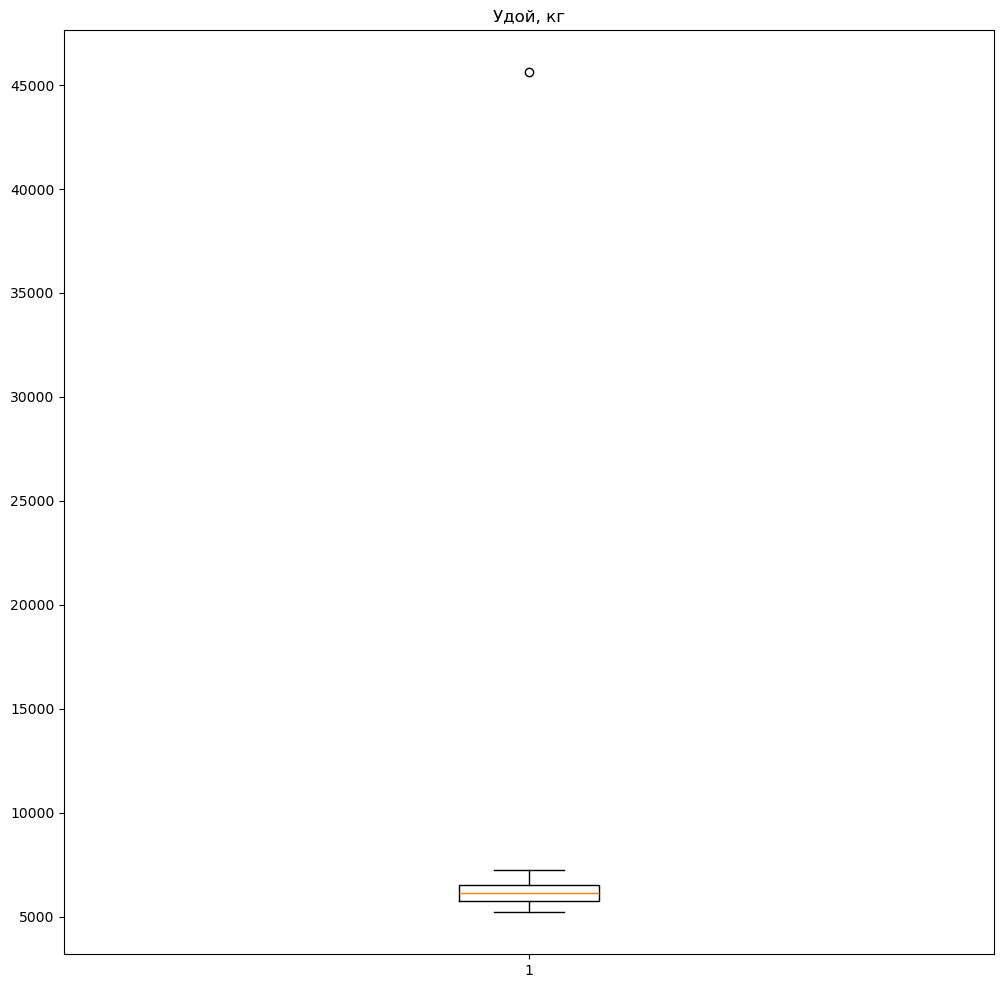

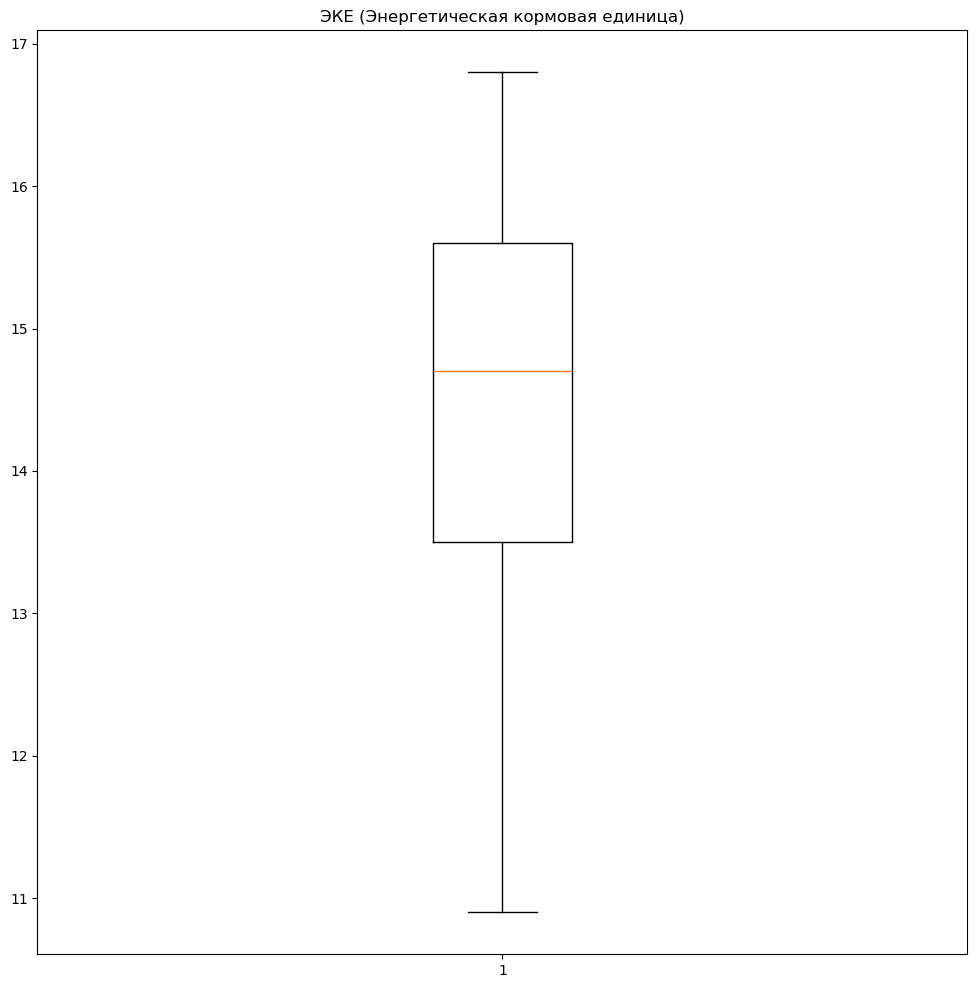

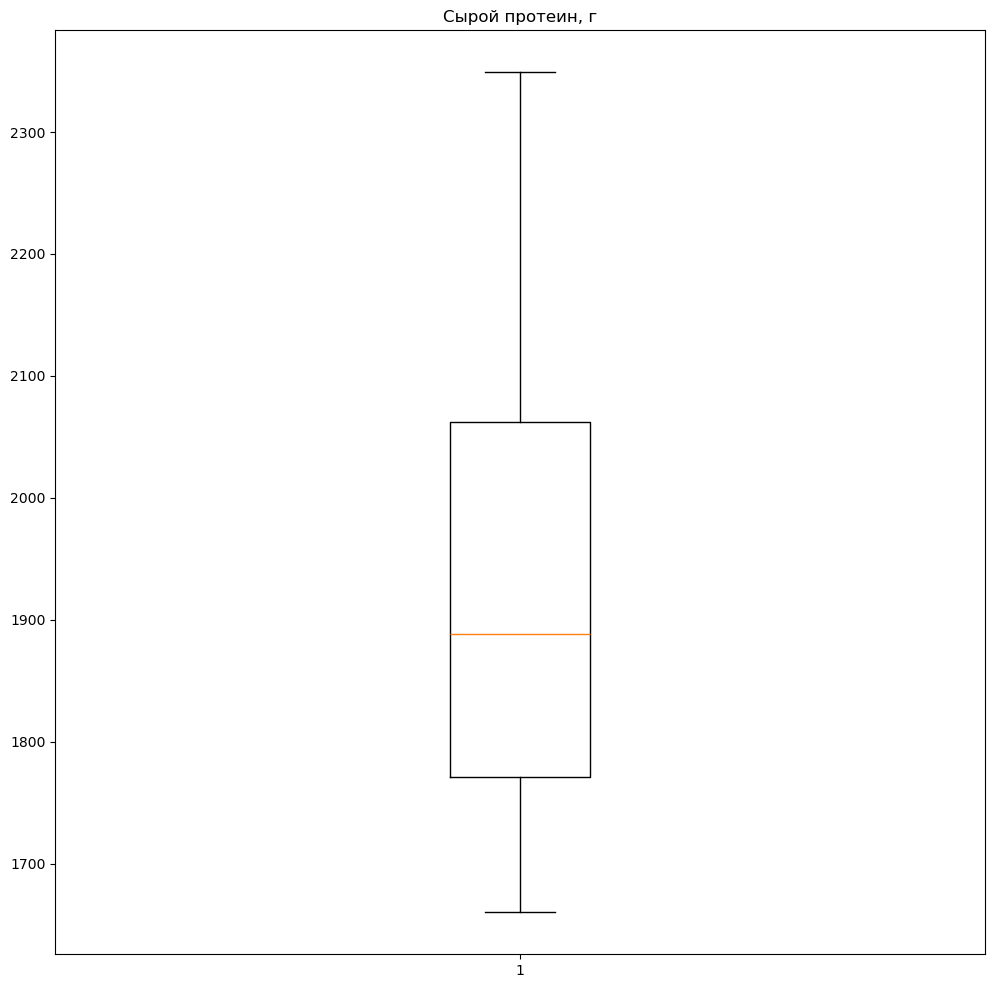

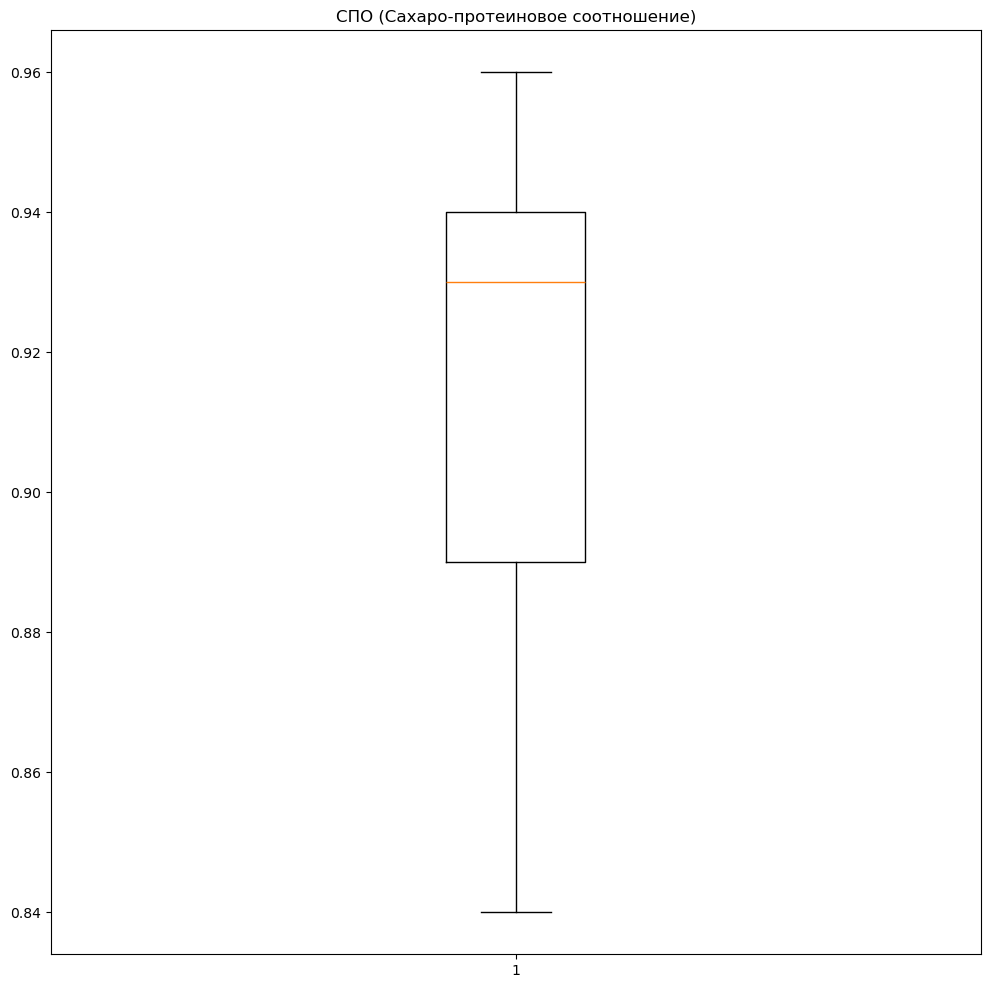

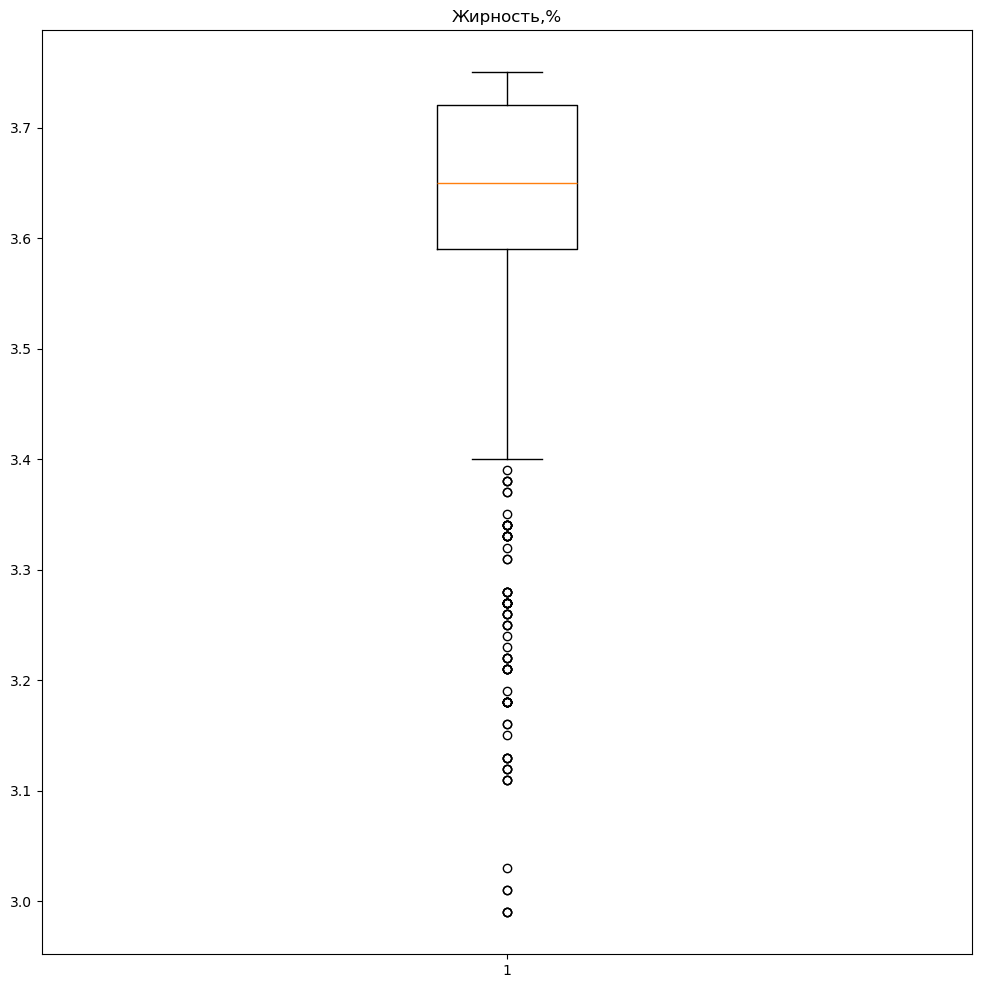

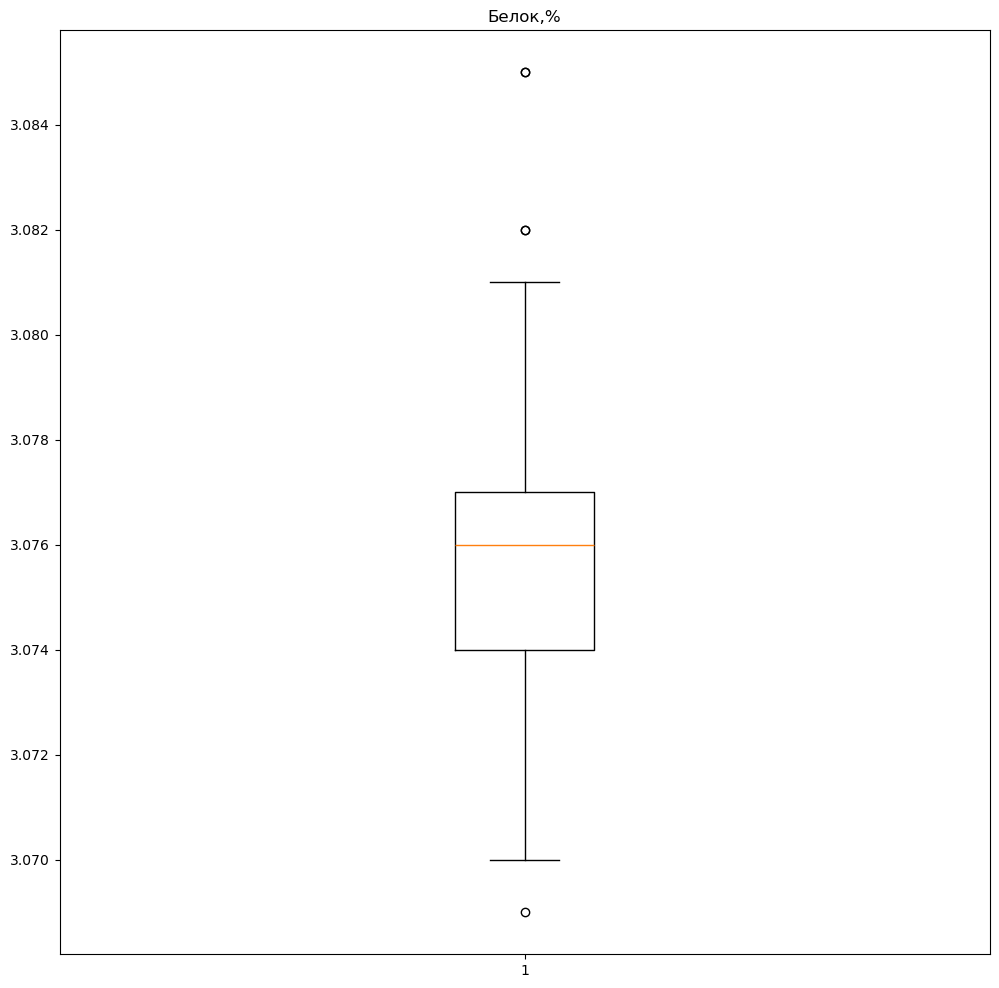

In [28]:
def get_numeric_boxplots(df, dict_names):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for i in num_cols[1:]:
        plt.figure(figsize=(12, 12))
        plt.boxplot(df[i])
        plt.title(dict_names[i])
        plt.show()

dict_names = {
    'id': 'id',
    'yield': 'Удой, кг',
    'ecu': 'ЭКЕ (Энергетическая кормовая единица)',
    'crude_protein': 'Сырой протеин, г',
    'sps': 'СПО (Сахаро-протеиновое соотношение)',
    'breed': 'Порода',
    'pasture_type': 'Тип пастбища',
    'sire_breed': 'порода папы_быка',
    'fat': 'Жирность,%',
    'protein': 'Белок,%',
    'milk_flavor': 'Вкус молока',
    'age': 'Возраст'
}
get_numeric_boxplots(data_ferma, dict_names)

Видно что в удое есть одна запись с огромным вбросом, избавимся от него

In [30]:
data_ferma[data_ferma['yield'] > 40000]

,id,yield,ecu,crude_protein,sps,breed,pasture_type,sire_breed,fat,protein,milk_flavor,age
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,True,Айдиал,3.22,3.076,True,True


In [31]:
data_ferma.drop(labels = [16], axis = 0, inplace= True)
data_ferma.reset_index(drop= True, inplace= True)

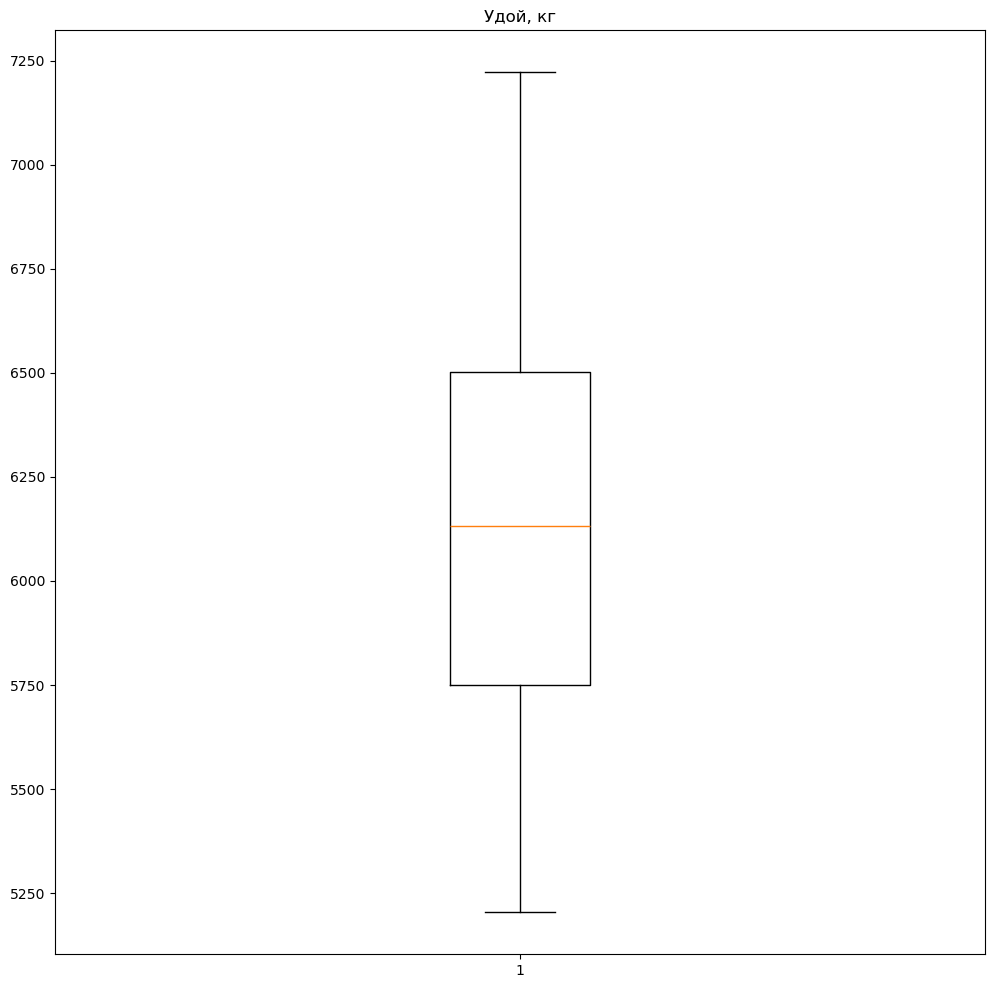

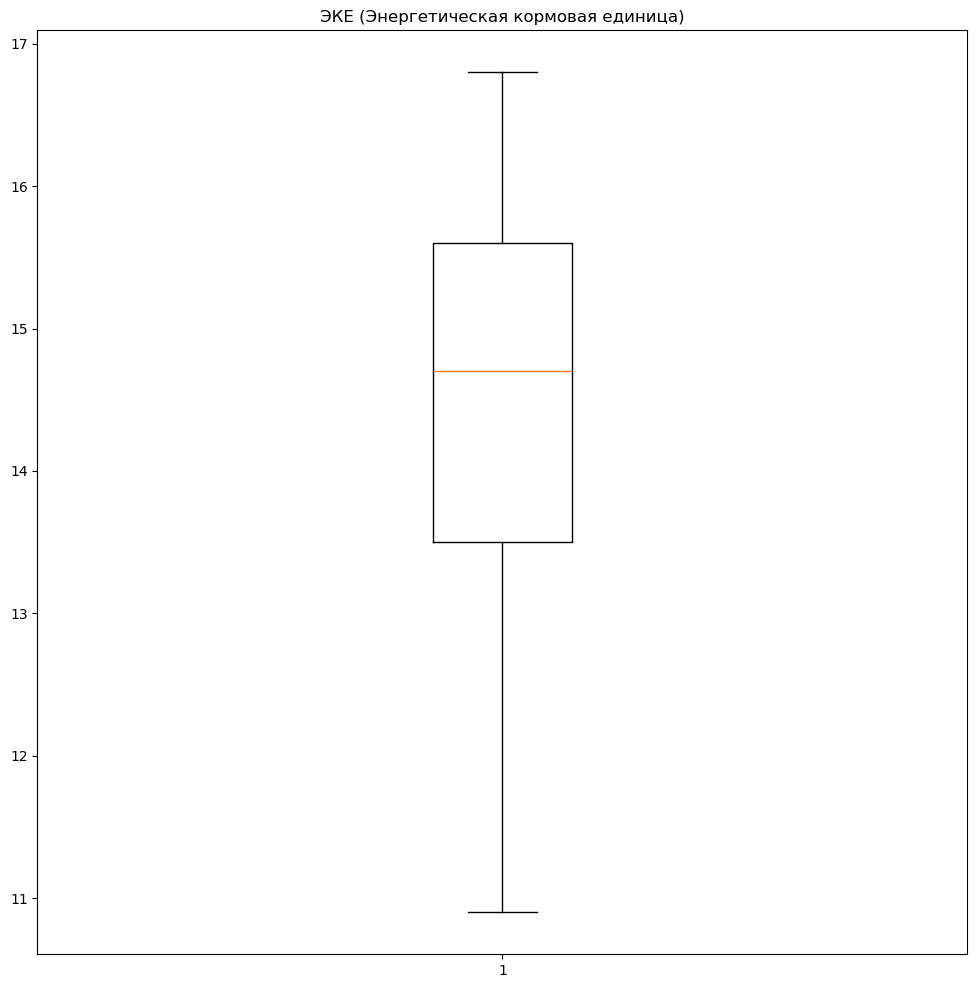

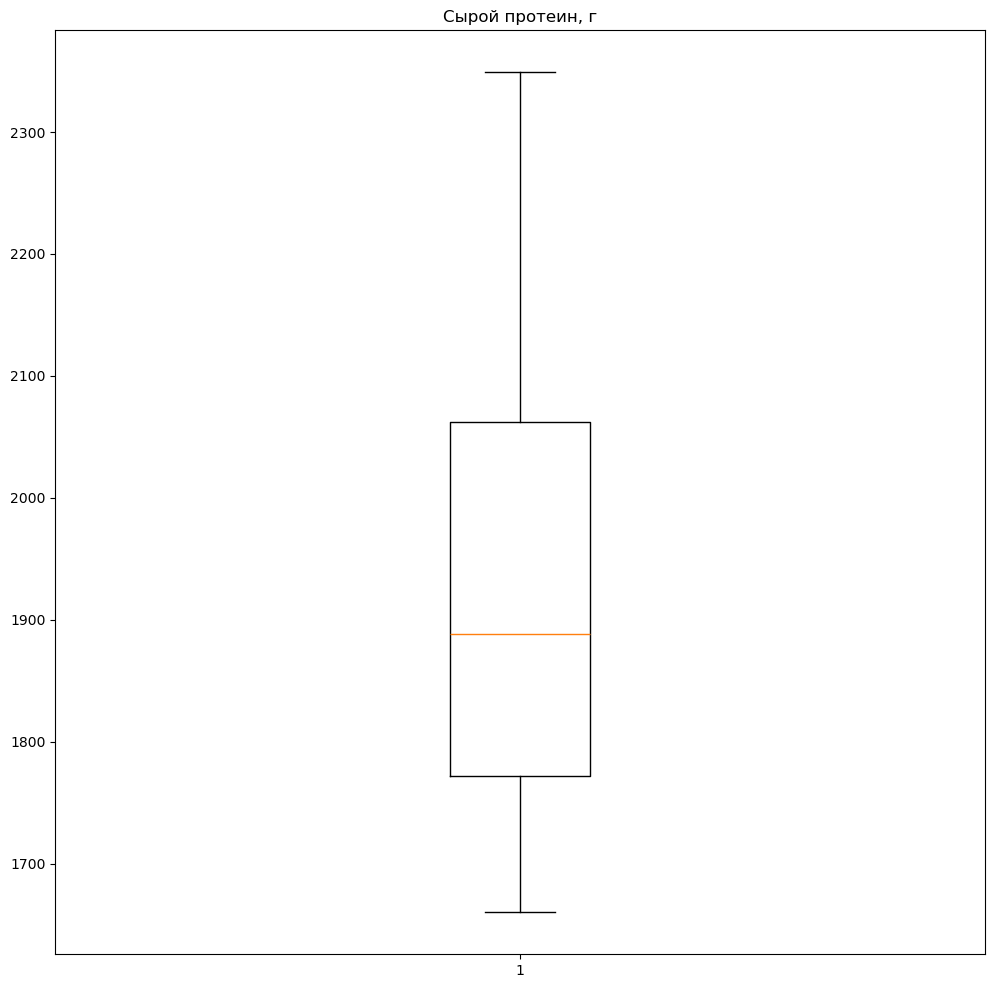

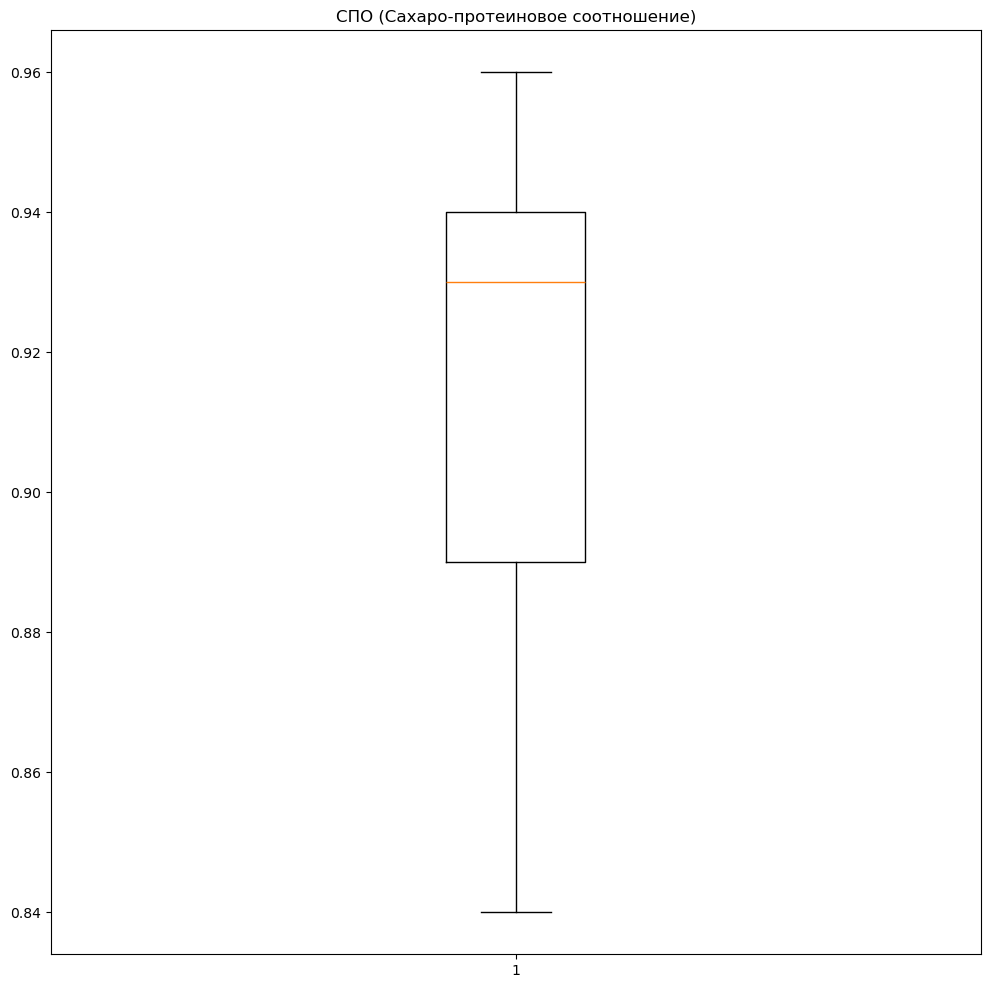

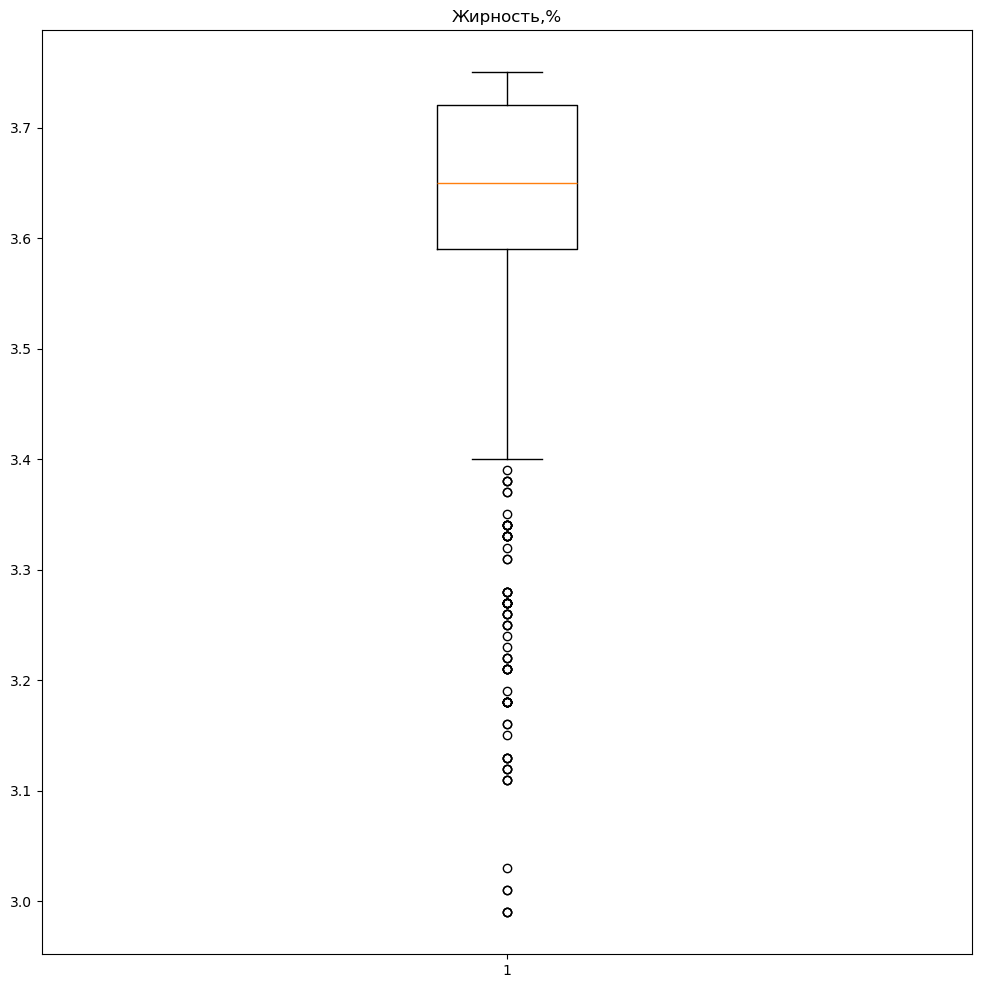

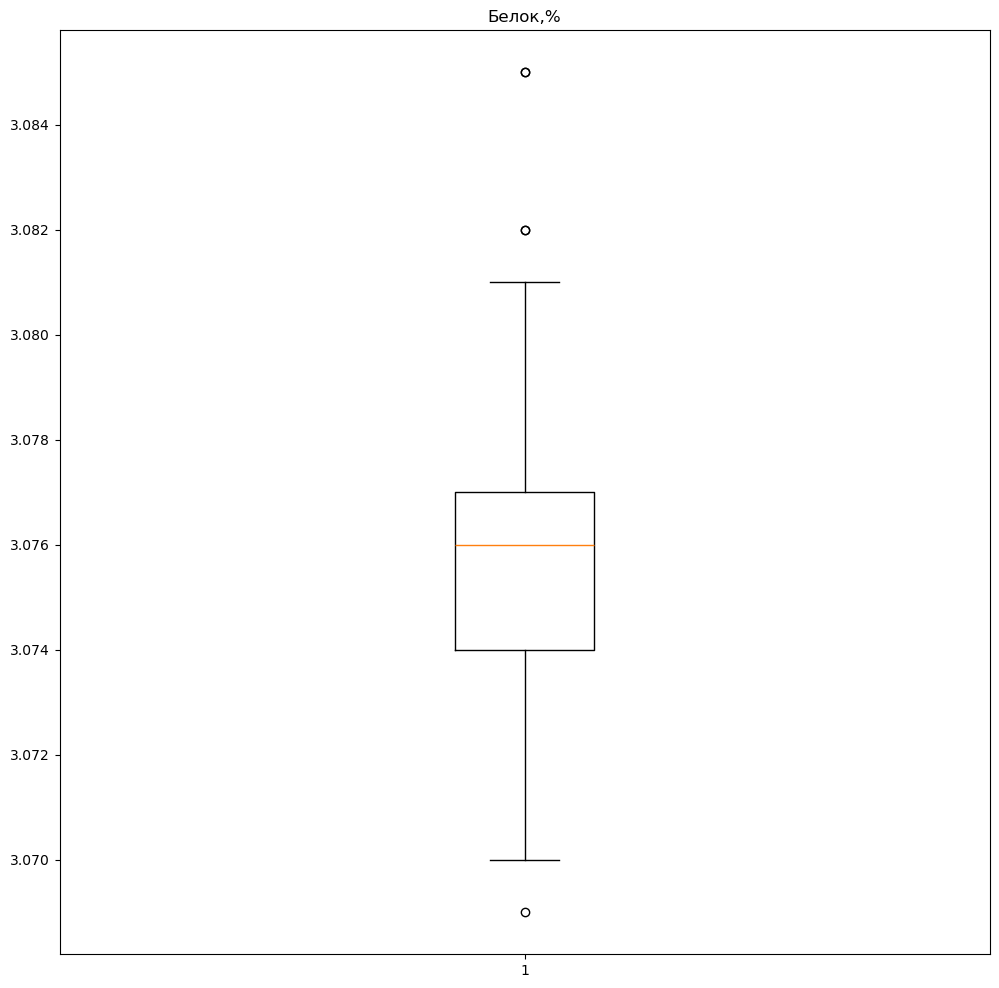

In [32]:
get_numeric_boxplots(data_ferma, dict_names)

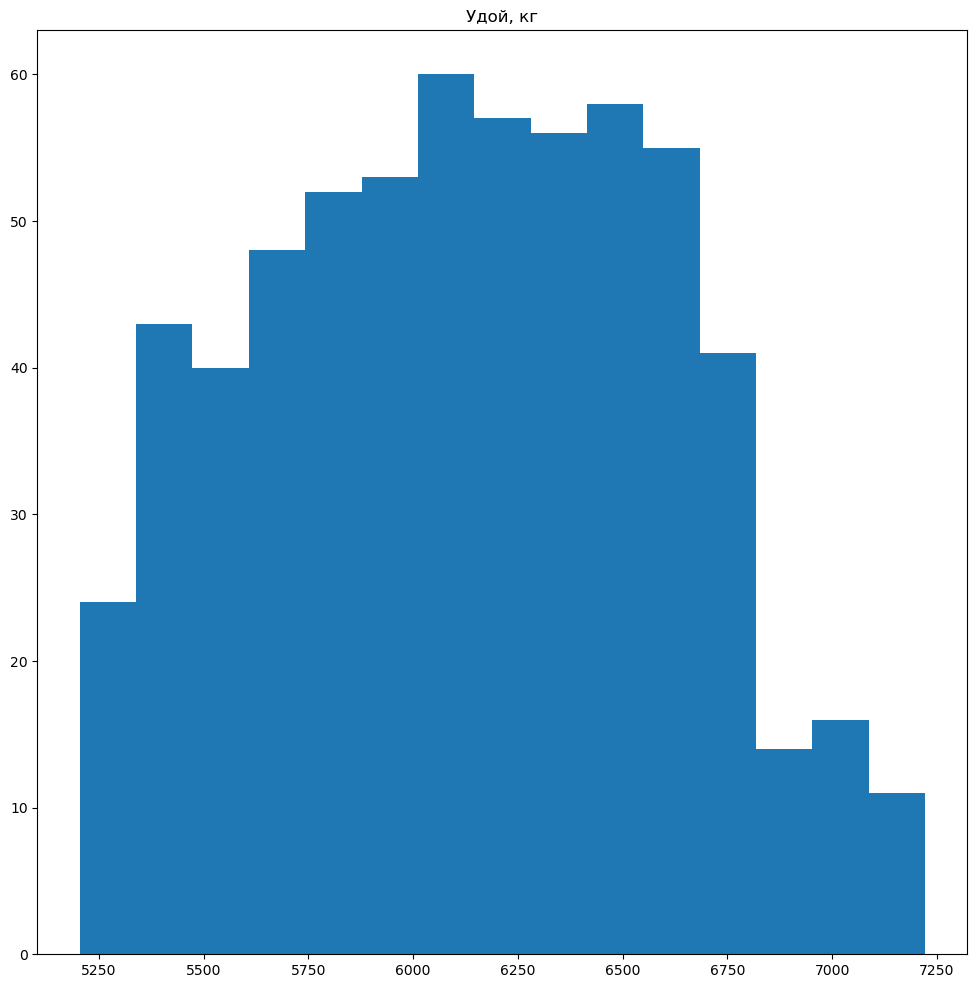

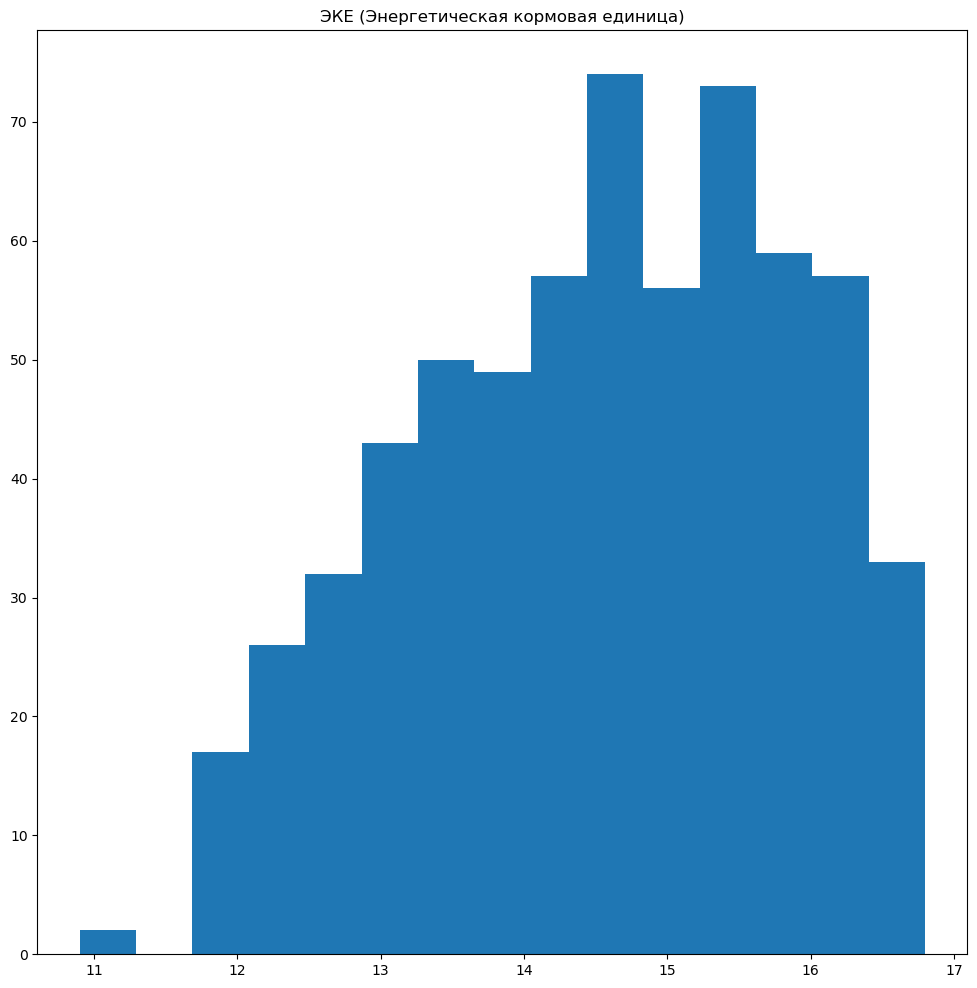

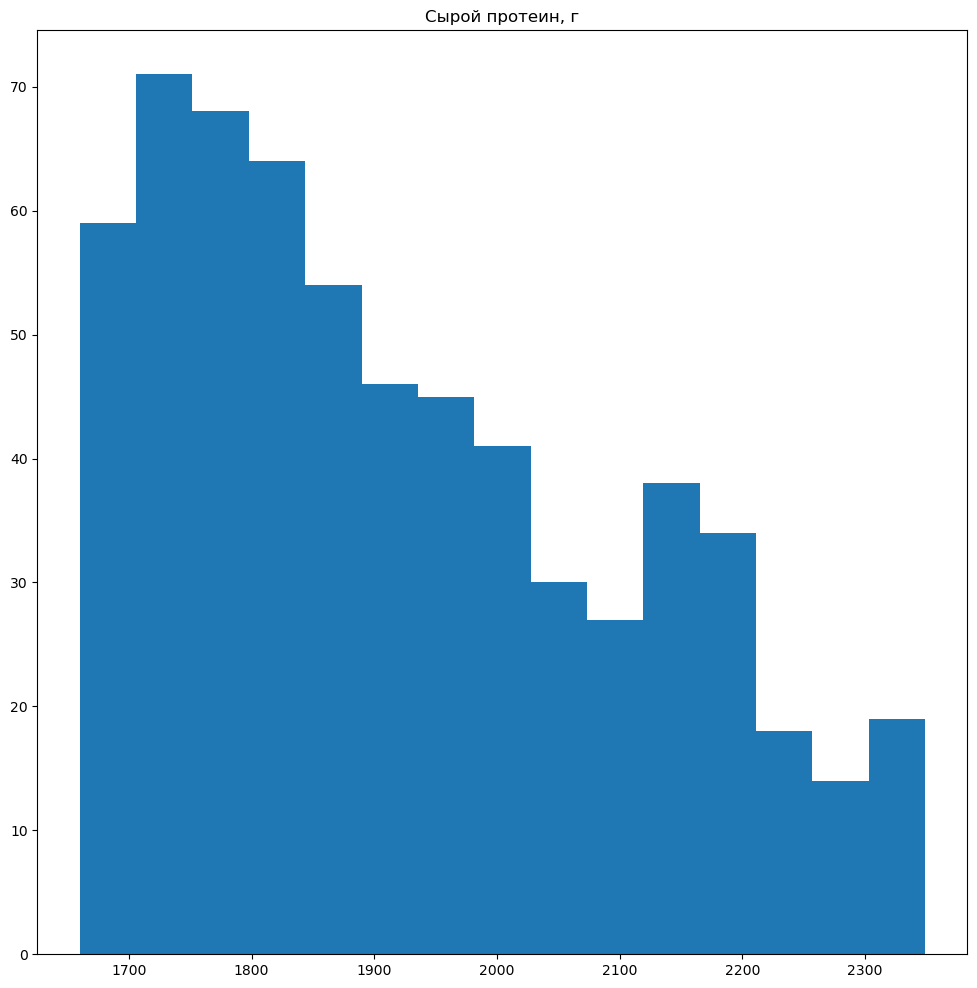

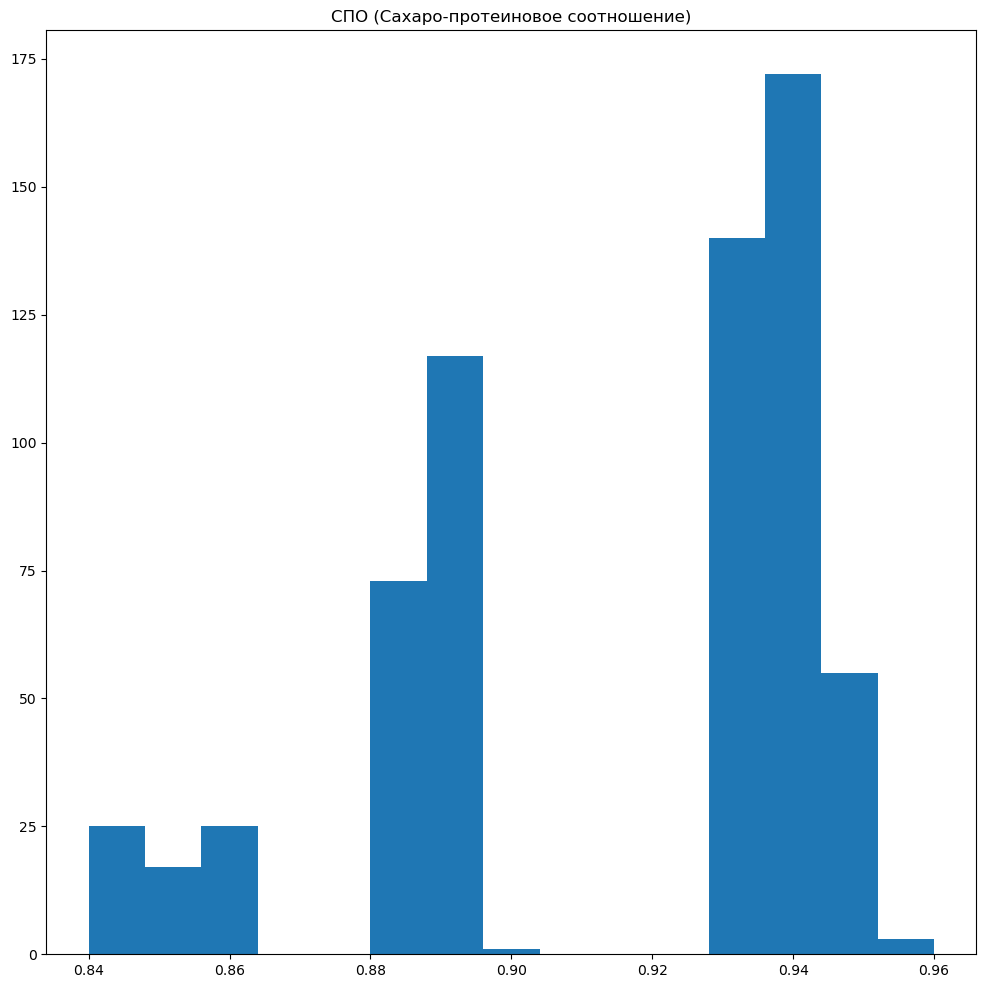

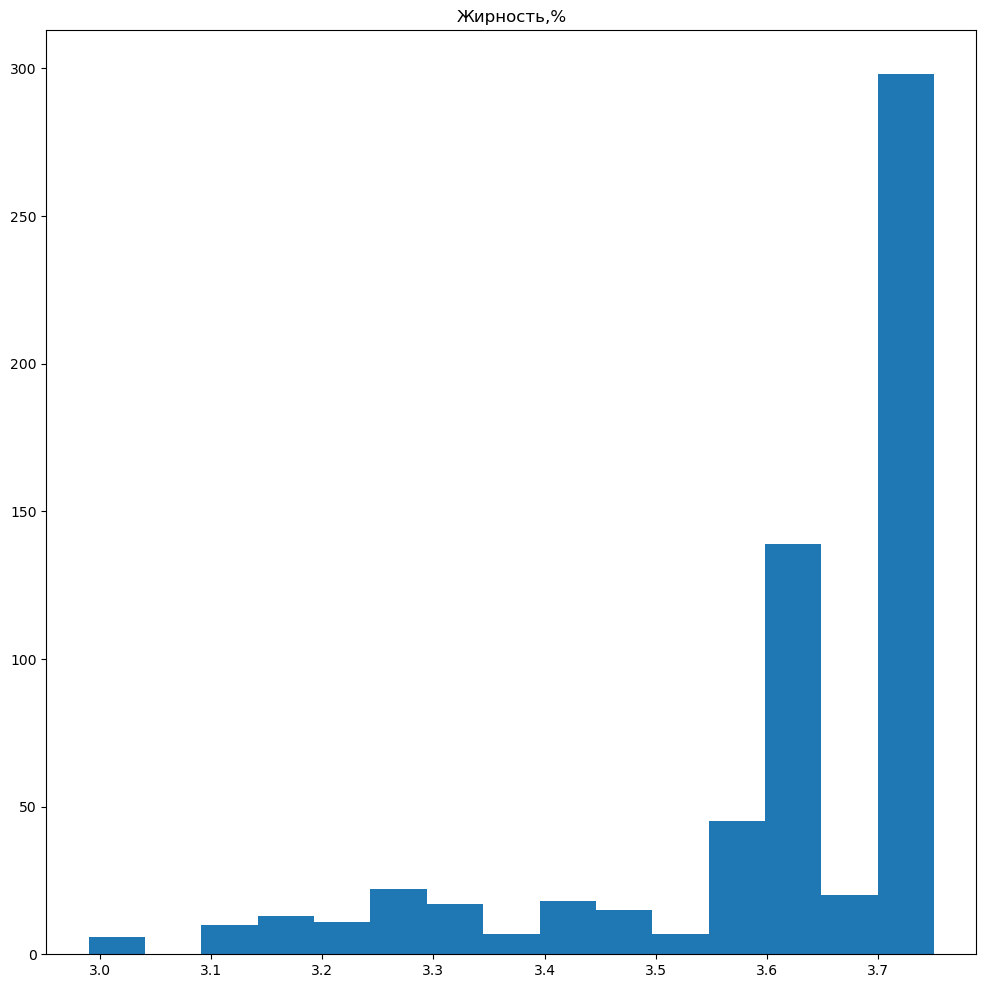

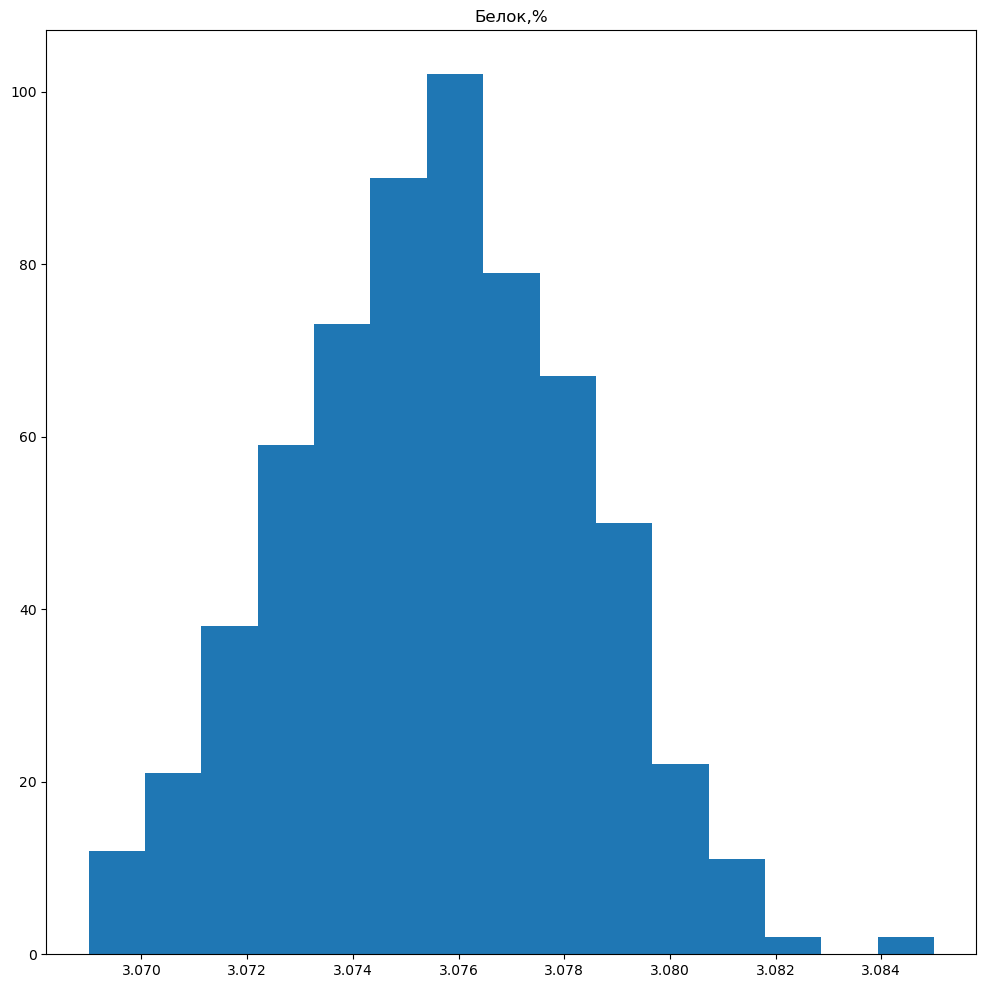

In [33]:
def get_numeric_hist(df, dict_names):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for i in num_cols[1:]:
        plt.figure(figsize=(12, 12))
        plt.hist(df[i], bins=15)
        plt.title(dict_names[i])
        plt.show()
get_numeric_hist(data_ferma, dict_names)

СПО ведет себя как категориальный признак, в целом в удое, ЭКЕ, белке, сыром протеине распределение нормальное со смещением, в жирности ненормальное

<a class='anchor' id='fourth-bullet'></a>
## Корреляционный анализ

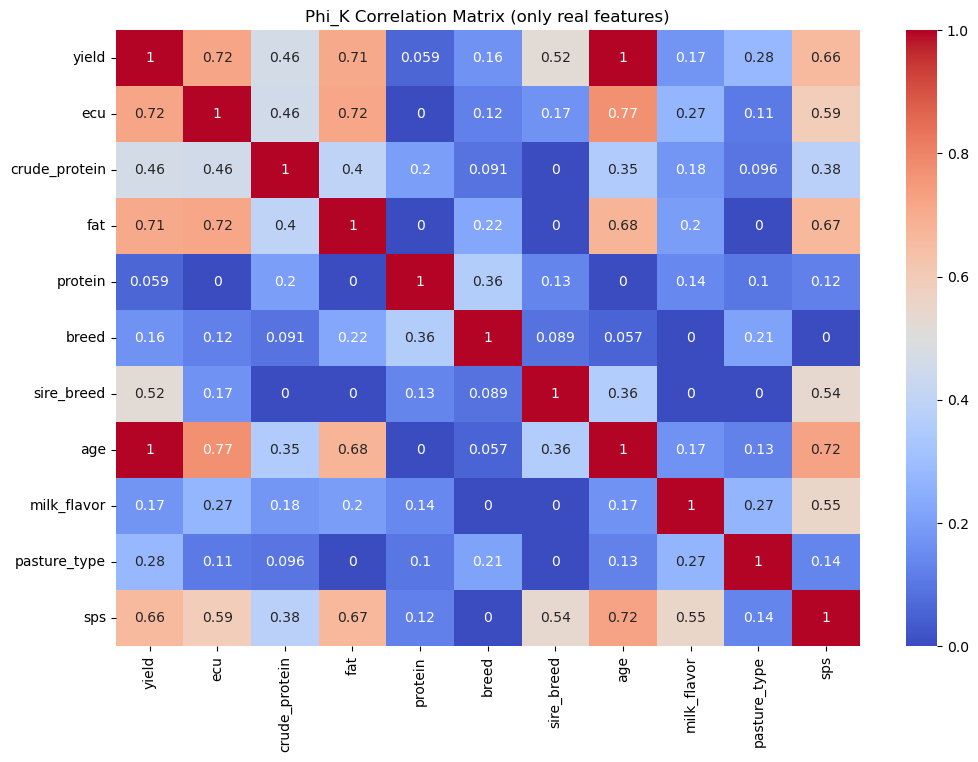

In [36]:
data_ferma = data_ferma.merge(data_dad)
num_cols = ['yield','ecu','crude_protein','fat','protein']
cat_cols = ['breed','sire_breed','age','milk_flavor','pasture_type','sps']
df = data_ferma[num_cols + cat_cols].copy()
corr = df.phik_matrix(interval_cols=num_cols)
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix (only real features)')
plt.show()

Получилась такая матрица кореляций, видно, что есть что-то странное между yield и age, вероятно все молодые коровы дают меньше молока чем старые, проверим на графиках, в остальном нормальная матрица корелляций

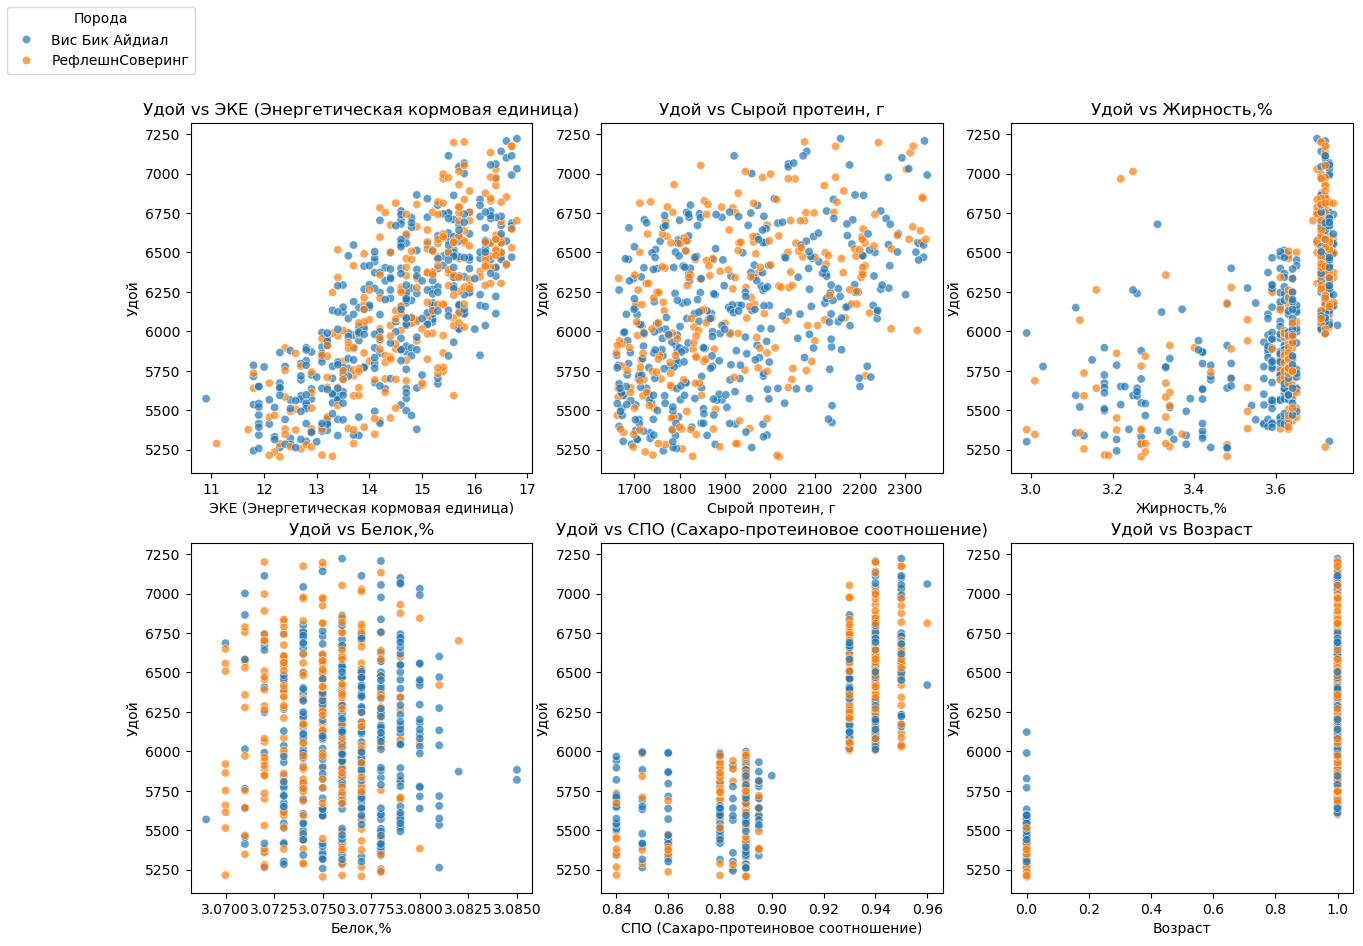

In [38]:
num_cols = ['ecu', 'crude_protein', 'fat', 'protein', 'sps', 'age']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, feat in zip(axes, num_cols):
    sns.scatterplot(
        data=df,
        x=feat, y='yield',
        hue='breed',
        alpha=0.7,
        ax=ax,
    )
    ax.set_title(f'Удой vs {dict_names[feat]}')
    ax.set_xlabel(dict_names[feat])
    ax.set_ylabel('Удой')
    ax.legend_.remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Порода', loc='upper left')
plt.show()

Наблюдается мультиколлинеарность между возрастом и удоем

На графиках мы видим, что да, удой и возраст действительно связаны так, что взрослые коровы всегда дают больше удоя, также видно, что более высокое СПО связано с более высоким удоем. Также можно сказать, что удой и ЭКЕ связаны квадратично, удой и сырой протеин почти не связаны, так как облако круглое, удой и жирность видно, что есть две большие группы и небольшой участок в них не входящий, тенденция к кластеризации, такая же наблюдается с СПО, белком и возрастом.

<a class='anchor' id='fifth-bullet'></a>
## Обучение модели линейной регрессии

In [41]:
def milk_yield(df,column_num, column_cat, y):
    X = df[column_num + column_cat]
    y = df[y]
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=RANDOM_STATE)
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_train_ohe = encoder.fit_transform(X_train[column_cat])
    X_test_ohe = encoder.transform(X_test[column_cat])
    encoder_col_names = encoder.get_feature_names_out()
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[column_num])
    X_test_scaled = scaler.transform(X_test[column_num])
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=column_num)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=column_num)
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    model_lr  = LinearRegression()
    model_lr = model_lr.fit(X_train, y_train)
    predictions = model_lr.predict(X_test)
    display(f'R2 : {r2_score(y_test,  predictions)}')
    display(f'МSЕ : {mean_squared_error(y_test, predictions)}')
    display(f'MAE : {mean_absolute_error(y_test, predictions)}')
    display(f'RМSЕ : {mean_squared_error(y_test, predictions, squared=False)}')
    residuals =  y_test - predictions
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(residuals, bins=50)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[1].scatter(x=predictions,y=residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()
    return encoder, scaler, model_lr, X_train, X_test, y_train, y_test

'R2 : 0.7844078173416967'

'МSЕ : 43887.015009660514'

'MAE : 164.24194463474925'

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


'RМSЕ : 209.4922791170608'

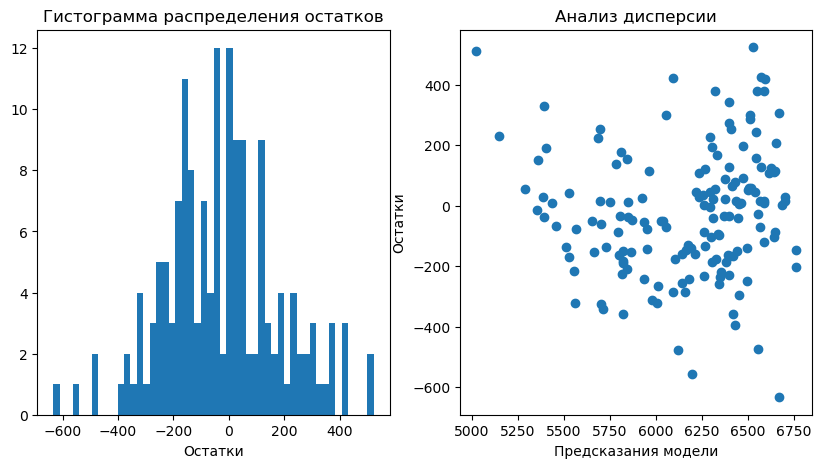

In [42]:
num_cols_1 = ['ecu', 'crude_protein', 'sps']
cat_cols_1 = ['breed', 'pasture_type', 'sire_breed', 'age']
encoder1, scaler1, model_lr1, X_train1, X_test1, y_train1, y_test1 = milk_yield(
    df=data_ferma,
    column_num=num_cols_1,
    column_cat=cat_cols_1,
    y='yield'
)

Видно, что у модели неплохое распределение остатков, но дисперсия принимает вид рупора, получается непостоянство остатков

'R2 : 0.7533370725243654'

'МSЕ : 50211.930075438904'

'MAE : 168.71353470005496'

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


'RМSЕ : 224.08018670877374'

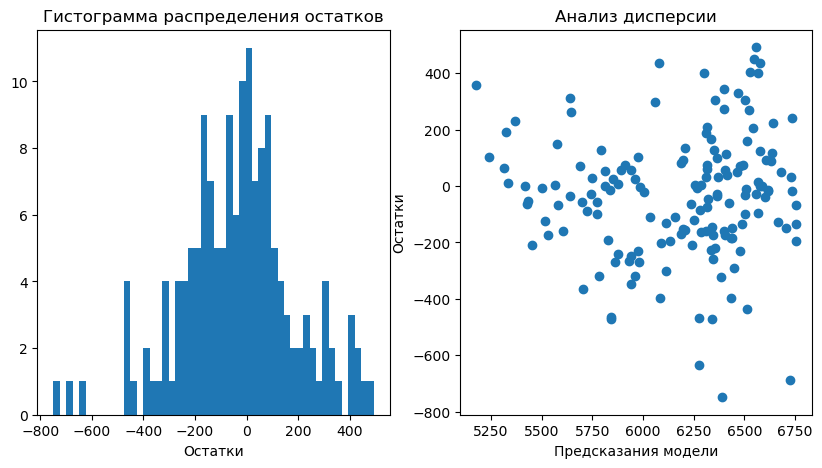

In [44]:
df2 = data_ferma.copy()
df2['ecu_sq'] = df2['ecu']**2
df2['sps'] = df2['sps'].astype(float)
df2['sps_bin'] = (df2['sps'] > 0.89).astype(int)
num_cols_2 = ['ecu_sq', 'crude_protein']
cat_cols_2 = ['breed', 'pasture_type', 'sire_breed', 'age', 'sps_bin']
encoder, scaler, model_lr, X_train, X_test, y_train, y_test = milk_yield(
    df=df2,
    column_num=num_cols_2,
    column_cat=cat_cols_2,
    y='yield'
)


Улусшили показатели, включая распределение и дисперсию

'R2 : 0.8258381115431239'

'МSЕ : 35453.25864125604'

'MAE : 143.4889391999736'

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


'RМSЕ : 188.29035727104042'

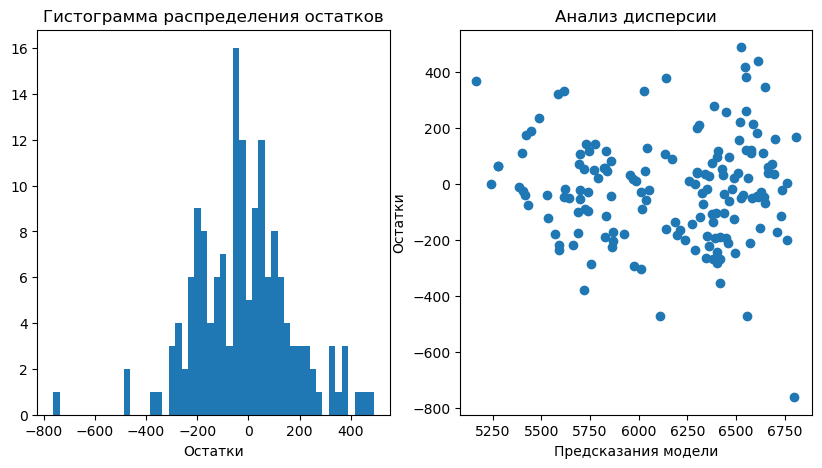

In [46]:
df3 = data_ferma.copy()
df3['sps'] = df3['sps'].astype(float)
df3['sps_bin'] = (df3['sps'] > 0.9).astype(int)
df3['ecu_sq'] = df3['ecu'] ** 2
num_cols_3 = ['crude_protein', 'fat', 'protein', 'ecu_sq']
cat_cols_3 = ['breed', 'pasture_type', 'sire_name', 'age', 'sps_bin']
encoder3, scaler3, lr3, X_train3, X_test3, y_train3, y_test3 = milk_yield(
    df=df3,
    column_num=num_cols_3,
    column_cat=cat_cols_3,
    y='yield'
)

Видно, что лучше всего по метрикам справилась модель номер 3, получим результаты по этой модели для коров для покупки

In [48]:
def milk_yield_buy(x_buy, encoder, scaler, model, num_cols, cat_cols):
    df = x_buy.copy()
    df['sps']      = df['sps'].astype(float)
    df['sps_bin']  = (df['sps'] > 0.9).astype(int)
    df['ecu_sq']   = df['ecu'] ** 2
    df = df.drop(columns=['sps','ecu'])
    X_num = df[num_cols]
    X_cat = df[cat_cols]
    X_ohe    = encoder.transform(X_cat)
    X_scaled = scaler.transform(X_num)
    ohe_cols = encoder.get_feature_names_out(cat_cols)
    X_ohe_df = pd.DataFrame(X_ohe,    columns=ohe_cols, index=df.index)
    X_num_df = pd.DataFrame(X_scaled, columns=num_cols, index=df.index)
    X_final  = pd.concat([X_ohe_df, X_num_df], axis=1)
    df_result = df.reset_index(drop=True).copy()
    df_result['pr_yield'] = model.predict(X_final)
    return df_result

data_buy['sps'] = data_ferma['sps'].astype(float).mean() * 1.05
data_buy['ecu'] = data_ferma['ecu'].mean() * 1.05
data_buy['crude_protein'] = data_ferma['crude_protein'].mean() * 1.05
df_buy_pred = milk_yield_buy(
    data_buy,
    encoder3, scaler3, lr3,
    num_cols_3, cat_cols_3
)

display(df_buy_pred.query('pr_yield > 6000'))

,breed,pasture_type,sire_breed,sire_name,fat,protein,age,crude_protein,sps_bin,ecu_sq,pr_yield
0,Вис Бик Айдиал,True,Айдиал,Геркулес,3.58,3.076,True,2019.947532,1,233.361138,6596.914336
1,Вис Бик Айдиал,False,Соверин,Буйный,3.54,3.081,False,2019.947532,1,233.361138,6274.317308
2,РефлешнСоверинг,False,Соверин,Барин,3.59,3.074,True,2019.947532,1,233.361138,6261.815649
3,РефлешнСоверинг,True,Айдиал,Буйный,3.40,3.061,True,2019.947532,1,233.361138,6690.414116
4,РефлешнСоверинг,False,Айдиал,Буйный,3.64,3.074,True,2019.947532,1,233.361138,6541.741649
5,РефлешнСоверинг,False,Соверин,Геркулес,3.63,3.053,False,2019.947532,1,233.361138,6600.472506
6,Вис Бик Айдиал,True,Айдиал,Геркулес,3.58,3.076,True,2019.947532,1,233.361138,6596.914336
7,Вис Бик Айдиал,False,Соверин,Буйный,3.57,3.079,True,2019.947532,1,233.361138,6478.851625
8,РефлешнСоверинг,False,Соверин,Барин,3.59,3.074,True,2019.947532,1,233.361138,6261.815649
9,РефлешнСоверинг,True,Айдиал,Буйный,3.40,3.079,False,2019.947532,1,233.361138,6327.032725


In [49]:
resid = y_test3.values - lr3.predict(X_test3)
lower, upper = np.quantile(resid, [0.025, 0.975])
print(f"95%-интервал остаточной ошибки: [{lower:.1f}, {upper:.1f}]")

95%-интервал остаточной ошибки: [-356.2, 379.0]


Для того, чтобы значение наверняка было больше 6000 как требует фермер вычтем из предсказаний 356 чтобы соответсвовать доверительному интервалу

In [51]:
data_buy['pr_yield'] = df_buy_pred['pr_yield'] - 356

In [52]:
len(data_buy[data_buy['pr_yield'] > 6000])

13

In [53]:
data_ferma['ecu_sq'] = data_ferma['ecu']**2
data_ferma['sps'] = data_ferma['sps'].astype(float)
data_ferma['sps_bin'] = (data_ferma['sps'] > 0.9).astype(int)
data_ferma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             628 non-null    int64  
 1   yield          628 non-null    int64  
 2   ecu            628 non-null    float64
 3   crude_protein  628 non-null    int64  
 4   sps            628 non-null    float64
 5   breed          628 non-null    object 
 6   pasture_type   628 non-null    bool   
 7   sire_breed     628 non-null    object 
 8   fat            628 non-null    float64
 9   protein        628 non-null    float64
 10  milk_flavor    628 non-null    bool   
 11  age            628 non-null    bool   
 12  sire_name      628 non-null    object 
 13  ecu_sq         628 non-null    float64
 14  sps_bin        628 non-null    int64  
dtypes: bool(3), float64(5), int64(4), object(3)
memory usage: 60.8+ KB


Получаем что по количеству удоя нам подходят 13 коров из 20

<a class='anchor' id='sixth-bullet'></a>
## Обучение модели логистической регрессии

In [56]:
X_cl = data_ferma.drop(['milk_flavor'], axis=1)
y_cl = data_ferma['milk_flavor']
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cl, y_cl, random_state=RANDOM_STATE)
cat_col_names = ['breed', 'pasture_type', 'sire_breed', 'age', 'sps_bin', 'sire_name']
num_col_names = ['crude_protein', 'ecu_sq', 'fat', 'protein']
encoder_cl = OneHotEncoder(drop='first', sparse_output= False)
X_train_ohe_cl = encoder_cl.fit_transform(X_train_cl[cat_col_names])
X_test_ohe_cl = encoder_cl.transform(X_test_cl[cat_col_names])
encoder_col_names_cl = encoder_cl.get_feature_names_out()
scaler_cl = StandardScaler()
X_train_scaled_cl = scaler_cl.fit_transform(X_train_cl[num_col_names])
X_test_scaled_cl = scaler_cl.transform(X_test_cl[num_col_names])
X_train_ohe_cl = pd.DataFrame(X_train_ohe_cl, columns= encoder_col_names_cl)
X_test_ohe_cl = pd.DataFrame(X_test_ohe_cl, columns= encoder_col_names_cl)
X_train_scaled_cl = pd.DataFrame(X_train_scaled_cl, columns= num_col_names)
X_test_scaled_cl = pd.DataFrame(X_test_scaled_cl, columns= num_col_names)
X_train_cl = pd.concat([X_train_ohe_cl, X_train_scaled_cl], axis=1)
X_test_cl = pd.concat([X_test_ohe_cl, X_test_scaled_cl], axis=1)
y_train_cl = y_train_cl.apply(lambda x: 1 if x == True else 0)
y_test_cl = y_test_cl.apply(lambda x: 1 if x == True else 0)
clf = LogisticRegression()
clf = clf.fit(X_train_cl, y_train_cl)
y_cl_pred = clf.predict(X_test_cl)

Text(0.5, 1.0, 'Матрица ошибок')

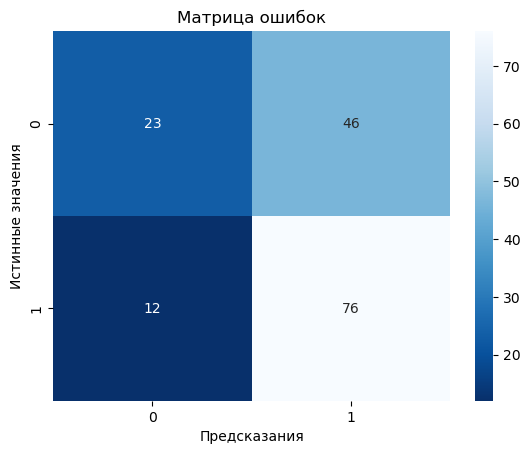

In [57]:
cm = confusion_matrix(y_test_cl, y_cl_pred)
sns.heatmap(cm, annot= True, fmt= 'd', cmap= 'Blues_r')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказания')
plt.title('Матрица ошибок')

Нам нужно максимизировать precision, чтобы уменьшить количество ложноположительных

In [59]:
acc = accuracy_score(y_test_cl, y_cl_pred)
precision = precision_score(y_test_cl, y_cl_pred)
recall = recall_score(y_test_cl, y_cl_pred)
print('Accuracy =', round(acc, 2))
print('Recall =', round(recall, 2))
print('Precision =', round(precision, 2))

Accuracy = 0.63
Recall = 0.86
Precision = 0.62


In [60]:
y_proba = clf.predict_proba(X_test_cl)[:,1]
data = pd.DataFrame(zip(y_test_cl, y_proba), columns= ['y_test_cl', 'y_proba']).sort_values(by= 'y_proba', ascending= False)
data.head()

,y_test_cl,y_proba
85,1,0.861349
110,1,0.842713
66,1,0.841492
51,1,0.839577
8,1,0.817328


In [61]:
for THRESHOLD in np.arange(0.7,0.85,0.01):
    preds = np.where(clf.predict_proba(X_test_cl)[:,1] > THRESHOLD, 1, 0)
    precision_res = precision_score(y_test_cl, preds, zero_division=1)
    acc_res = accuracy_score(y_test_cl, preds)
    print('Порог', round(THRESHOLD, 2), 'значение Precision:', round(precision_res, 2), 'значение Accuracy:', round(acc_res, 2))

Порог 0.7 значение Precision: 0.82 значение Accuracy: 0.62
Порог 0.71 значение Precision: 0.82 значение Accuracy: 0.6
Порог 0.72 значение Precision: 0.82 значение Accuracy: 0.59
Порог 0.73 значение Precision: 0.83 значение Accuracy: 0.59
Порог 0.74 значение Precision: 0.87 значение Accuracy: 0.58
Порог 0.75 значение Precision: 0.88 значение Accuracy: 0.57
Порог 0.76 значение Precision: 0.86 значение Accuracy: 0.54
Порог 0.77 значение Precision: 0.86 значение Accuracy: 0.54
Порог 0.78 значение Precision: 0.81 значение Accuracy: 0.5
Порог 0.79 значение Precision: 0.77 значение Accuracy: 0.48
Порог 0.8 значение Precision: 0.89 значение Accuracy: 0.48
Порог 0.81 значение Precision: 1.0 значение Accuracy: 0.48
Порог 0.82 значение Precision: 1.0 значение Accuracy: 0.46
Порог 0.83 значение Precision: 1.0 значение Accuracy: 0.46
Порог 0.84 значение Precision: 1.0 значение Accuracy: 0.46
Порог 0.85 значение Precision: 1.0 значение Accuracy: 0.45


Возьмем 0.81 так как это минимальный порог при котором precision 1

In [63]:
THRESHOLD = 0.81
preds = np.where(clf.predict_proba(X_test_cl)[:,1] > THRESHOLD, 1, 0)

In [64]:
acc_res = accuracy_score(y_test_cl, preds)
precision_res = precision_score(y_test_cl, preds)
recall_res = recall_score(y_test_cl, preds)
print('Accuracy =', round(acc_res, 2))
print('Recall =', round(recall_res, 2))
print('Precision =', round(precision_res, 2))

Accuracy = 0.48
Recall = 0.07
Precision = 1.0


Text(0.5, 1.0, 'Матрица ошибок')

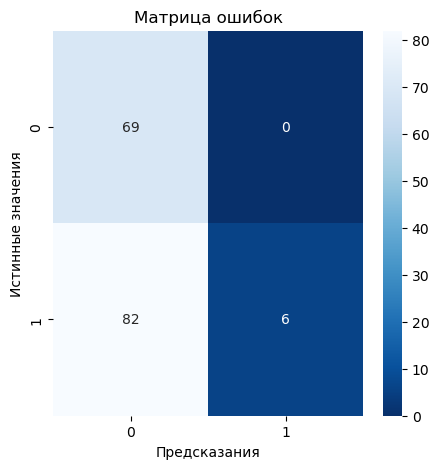

In [65]:
cm_2 = confusion_matrix(y_test_cl, preds)
fig_cm2, ax_cm2 = plt.subplots(figsize=(5,5))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues_r', ax=ax_cm2)
ax_cm2.set_ylabel('Истинные значения')
ax_cm2.set_xlabel('Предсказания')
ax_cm2.set_title('Матрица ошибок')


In [66]:
data_buy['ecu_sq'] = data_buy['ecu'] ** 2
data_buy['sps'] = data_buy['sps'].astype(float)
data_buy['sps_bin'] = (data_buy['sps'] > 0.9).astype(int)
data_buy.head()

,breed,pasture_type,sire_breed,sire_name,fat,protein,age,sps,ecu,crude_protein,pr_yield,ecu_sq,sps_bin
0,Вис Бик Айдиал,True,Айдиал,Геркулес,3.58,3.076,True,0.958744,15.276162,2019.947532,6240.914336,233.361138,1
1,Вис Бик Айдиал,False,Соверин,Буйный,3.54,3.081,False,0.958744,15.276162,2019.947532,5918.317308,233.361138,1
2,РефлешнСоверинг,False,Соверин,Барин,3.59,3.074,True,0.958744,15.276162,2019.947532,5905.815649,233.361138,1
3,РефлешнСоверинг,True,Айдиал,Буйный,3.40,3.061,True,0.958744,15.276162,2019.947532,6334.414116,233.361138,1
4,РефлешнСоверинг,False,Айдиал,Буйный,3.64,3.074,True,0.958744,15.276162,2019.947532,6185.741649,233.361138,1


In [67]:
X_new_cl = data_buy.drop(['ecu', 'sps'], axis=1)
X_new_cl_ohe = encoder_cl.transform(X_new_cl[cat_col_names])
X_new_cl_scaled = scaler_cl.transform(X_new_cl[num_col_names])

X_new_cl_ohe = pd.DataFrame(X_new_cl_ohe, columns= encoder_col_names_cl)
X_new_cl_scaled = pd.DataFrame(X_new_cl_scaled, columns= num_col_names)
X_new_cl = pd.concat([X_new_cl_ohe, X_new_cl_scaled], axis=1)

preds = np.where(clf.predict_proba(X_new_cl)[:,1] > THRESHOLD, 1, 0)

In [68]:
clf.predict_proba(X_new_cl)[:,1]

array([0.70777115, 0.66017172, 0.57147911, 0.36360694, 0.55586729,
       0.1043286 , 0.70777115, 0.65960341, 0.57147911, 0.74218301,
       0.16612914, 0.515982  , 0.10323735, 0.66104579, 0.57147911,
       0.46128034, 0.69296301, 0.10274432, 0.42023366, 0.55586729])

In [69]:
taste = []
for pred in preds:
    if pred == 1:
        taste.append('вкусно')
    else:
        taste.append('не вкусно')
taste

['не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно']

In [70]:
data_buy['milk_flavor'] = taste
data_buy

,breed,pasture_type,sire_breed,sire_name,fat,protein,age,sps,ecu,crude_protein,pr_yield,ecu_sq,sps_bin,milk_flavor
0,Вис Бик Айдиал,True,Айдиал,Геркулес,3.58,3.076,True,0.958744,15.276162,2019.947532,6240.914336,233.361138,1,не вкусно
1,Вис Бик Айдиал,False,Соверин,Буйный,3.54,3.081,False,0.958744,15.276162,2019.947532,5918.317308,233.361138,1,не вкусно
2,РефлешнСоверинг,False,Соверин,Барин,3.59,3.074,True,0.958744,15.276162,2019.947532,5905.815649,233.361138,1,не вкусно
3,РефлешнСоверинг,True,Айдиал,Буйный,3.40,3.061,True,0.958744,15.276162,2019.947532,6334.414116,233.361138,1,не вкусно
4,РефлешнСоверинг,False,Айдиал,Буйный,3.64,3.074,True,0.958744,15.276162,2019.947532,6185.741649,233.361138,1,не вкусно
5,РефлешнСоверинг,False,Соверин,Геркулес,3.63,3.053,False,0.958744,15.276162,2019.947532,6244.472506,233.361138,1,не вкусно
6,Вис Бик Айдиал,True,Айдиал,Геркулес,3.58,3.076,True,0.958744,15.276162,2019.947532,6240.914336,233.361138,1,не вкусно
7,Вис Бик Айдиал,False,Соверин,Буйный,3.57,3.079,True,0.958744,15.276162,2019.947532,6122.851625,233.361138,1,не вкусно
8,РефлешнСоверинг,False,Соверин,Барин,3.59,3.074,True,0.958744,15.276162,2019.947532,5905.815649,233.361138,1,не вкусно
9,РефлешнСоверинг,True,Айдиал,Буйный,3.40,3.079,False,0.958744,15.276162,2019.947532,5971.032725,233.361138,1,не вкусно


Получили полные предсказания, осталось выбрать нужных

In [72]:
selection = data_buy.query('pr_yield > 6000 & milk_flavor == "вкусно"')
selection

,breed,pasture_type,sire_breed,sire_name,fat,protein,age,sps,ecu,crude_protein,pr_yield,ecu_sq,sps_bin,milk_flavor


Получилось, что ни одна корова не подходит

<a class='anchor' id='seventh-bullet'></a>
## Итоговые выводы

Целью данного исседования была разработка модели машинного обучения, которая поможет молочному хозяйству управлять рисками и принимать объективное решение о покупке животных.

Первым этапом была выполнена работа по ознакомлению с данными и их предобработке.
Следующим этапом нами был проведен исследовательский анализ данных.
Нами были сделаны следующие выводы:

Жирность молока в молочном хозяйстве фермера немного больше, чем в "ЭкоФерме": 3.6-3.7 % против 3.5-3.6 %.
Содержание белка в молоке с обоих хозяйств одинаковое.
В столбце `yield` датафрейма `data_ferma` был обнаружен и удалён один выброс.
Из всех количественных признаков нормальное распределение имеет только признак `Белок` в датафрейме `data_ferma`.
Далее нами был выполнен корреляционный анализ данных.
В ходе работы мы выяснили, что между целевым признаком `yield` и входными признаками наблюдается как линейная, так и нелинейная зависимости. Выявлена зависимость целевого признака `yield` от входного категориального признака Возраст. Также замечена положительная корреляция между признаками ЭКЕ и СПО, ЭКЕ и Жирность, СПО и Жирность.

После этого мы перешли к обучению модели линейной регресии для предсказания удоя коров.
Мы подготовили данные из датафрейма ferma_main и обучили три разных модели:

Для модели № 1 мы исключили такие признаки как: 'Вкус молока', т.к. этот параметр мы получем на выходе продукта и на наш целевой признак 'Удой' он не оказывает влияния, а также по той же причине мы исключили 'Жирность' и 'Белок'.
Для модели № 2 мы убрали нелинейность в зависимости признаков 'Удой' и 'СПО' путем преобразования признака 'СПО' в категориальный бинарный, используя в качестве границы значение 0.9; а также мы убрали нелинейность и в зависимости признаков 'Удой' и 'ЭКЕ' путем возведения значений 'ЭКЕ' в квадрат.
Для модели № 3 мы добавили в данные новый признак 'Имя папы' из датафрейма `data_dad`. Три модели мы сравнили по основным метрикам: R2, MAE, MSE, RMSE, построили для каждой модели гистограмму распределения остатков и диаграмму рассеяния для анализа дисперсии, рассчитали доверительный интервал.
Исходя из сравнения метрик мы сделали вывод, что модель № 3 наиболее точна, ее предсказания в среднем меньше отличаются от истинных значений, чем у первых двух моделей и доверительный интервал больше.
Выбрав модель № 3 мы сделали предсказания удоя коров на данных датафрейма `data_buy`.

Следующей нашей задачей стала задача классификации для предсказания вкусного и не вкусного молока.
Мы подготовили данные из датафрейма ferma_main и обучили модель, после чего построили матрицу корреляции и рассчитали основные метрики модели (Accuracy, Recall, Precision).
Так как фермеру важно, чтобы молоко всегда было вкусным, мы минимизировали ложноположительные предсказания путем подбора порога классификации и улучшения метрики Precision.
После настройки модели мы сделали предсказания вкуса молока на данных датафрейма `data_buy`.
По итогу было получено, что ни одна из коров рассматриваемых для покупки не дает нужной вероятности того, что молоко у нее будет вкусным

Я думаю, что качество модели можно улучшить несколькими способами, например добавить больше релевантных данных, в т. ч. рассмотреть признаки СПО и возраста не как бинарные, а для этого не хватает данных. Кроме того, возможно добавить новые признаки или уточнить информацию по ЭКЕ, сырому протеину и СПО, для покупаемых коров